## Regressão Logística:

### Apresente os dados utilizados, descrevendo o objetivo da análise e as variáveis de interesse.

Serão utilizados dois arquivos, cada um contendo as seguintes colunas:

- `device_id`
- `time`
- `distance`
- `noise`

Cada arquivo contém informações de um sensor ao longo de um período. A coluna noise foi classificada manualmente indicando se este registro possui anomalia. 
O objetivo da análise é verificar a possibilidade de classificar se uma leitura do sensor possui ruído ou não.
Para isso, serão adicionadas algumas colunas derivadas de operações matemática sobre os dados de cada leitura.
Estas operações servem para relacionar a leitura atual com leituras mais antigas.


### Função que carrega o arquivo e executa as operações matemáticas

In [42]:
import pandas as pd
import numpy as np

def load_file(filename: str) -> pd.DataFrame:
    # Carregar a base de dados
    df = pd.read_csv(filename, parse_dates=["time"], dtype={"distance": float}) # distance: distância em milímetros
    df["time"] += pd.Timedelta(hours=-3) # corrige horário fuso horário do Brasil
    df["t"] = df["time"].astype(np.int64) / 1e9 # converte horário para segundos (Unix timestamp)
    df = df.dropna(subset=["distance", "time", "t"]) # remove linhas com valores faltantes
    df = df.sort_values(by="time")


    df["diff_d1"] = df["distance"].diff(periods=1) # calcula a diferença de distância entre as amostras
    df["diff_d2"] = df["distance"].diff(periods=2) # calcula a diferença de distância com 2 amostras de diferença
    df["diff_d3"] = df["distance"].diff(periods=3) # calcula a diferença de distância com 3 amostras de diferença
    df["diff_d4"] = df["distance"].diff(periods=4)
    df["diff_d5"] = df["distance"].diff(periods=5)

    df["diff_t"] = df["t"].diff() # calcula a diferença de tempo entre as amostras
    df['dddt'] = df["diff_d1"] / df["diff_t"] # calcula a velocidade entre as amostras (mm/s)

    df = df.dropna(subset=["diff_d1", "diff_d2", "diff_d3", "diff_d4", "diff_d5", "dddt"]) # remove linhas com valores faltantes

    return df # retorna o dataframe


### Função que separa os dados de treinamento e teste e treina o modelo

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

def fit_model(X, y, test_size=0.3, scale=False)-> LogisticRegression:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # divide os dados em treino e teste
    if scale:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=X.columns)
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=X.columns)

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    return model, X_test, y_test, scaler if scale else None


### Carrega o arquivo com dados do sensor

In [44]:
device_833 = "data-1740136119968-noise.csv"
device_468 = "data-1740190051056-noise.csv"

df = load_file(device_833)

print(df.head())


   device_id                time  distance  noise             t  diff_d1  \
5        833 2025-02-14 21:33:48     396.0  False  1.739569e+09     -2.0   
6        833 2025-02-14 21:38:48     398.0  False  1.739569e+09      2.0   
7        833 2025-02-14 21:43:48     398.0  False  1.739569e+09      0.0   
8        833 2025-02-14 21:48:48     392.0  False  1.739570e+09     -6.0   
9        833 2025-02-14 21:59:16     388.0  False  1.739570e+09     -4.0   

   diff_d2  diff_d3  diff_d4  diff_d5  diff_t      dddt  
5     -4.0     -8.0    -10.0    -12.0   301.0 -0.006645  
6      0.0     -2.0     -6.0     -8.0   300.0  0.006667  
7      2.0      0.0     -2.0     -6.0   300.0  0.000000  
8     -6.0     -4.0     -6.0     -8.0   300.0 -0.020000  
9    -10.0    -10.0     -8.0    -10.0   628.0 -0.006369  


### Obtenha o modelo de regressão logística para os dados. Quais os parâmetros encontrados?


In [ ]:
features = ['diff_t', 'distance', 'diff_d1', 'diff_d2', 'diff_d3', 'diff_d4', 'diff_d5', 'dddt']
target = "noise"
X = df[features] # seleciona as colunas de entrada
y = df[target] # seleciona a coluna de saída
test_size = 0.3 # 30% dos dados para teste

model, X_test, y_test, scaler = fit_model(X, y, test_size=test_size, scale=True)

# Parâmetros do modelo
print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)


Coeficientes: [[0.06779579 2.91086405 0.09096582 0.09380496 0.09000359 0.12090632
  0.15234501 0.13196399]]
Intercepto: [-6.62474518]


### Apresente o gráfico contendo a curva de probabilidades encontrada entre as variáveis de interesse e as classes avaliadas.

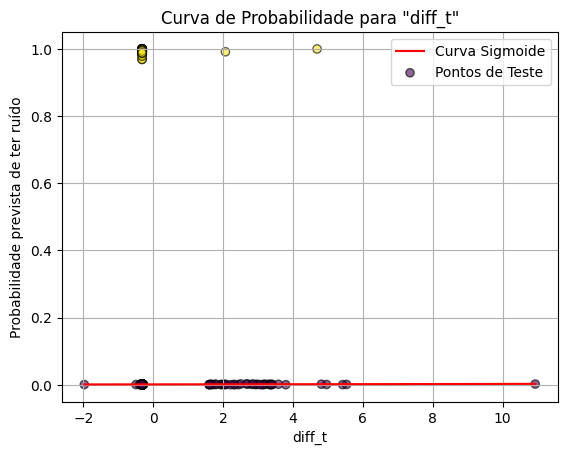

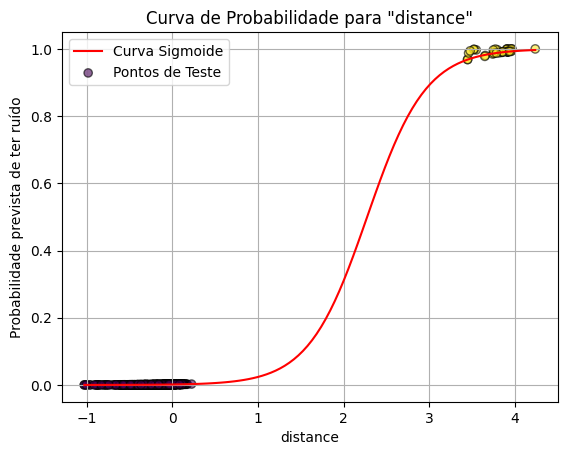

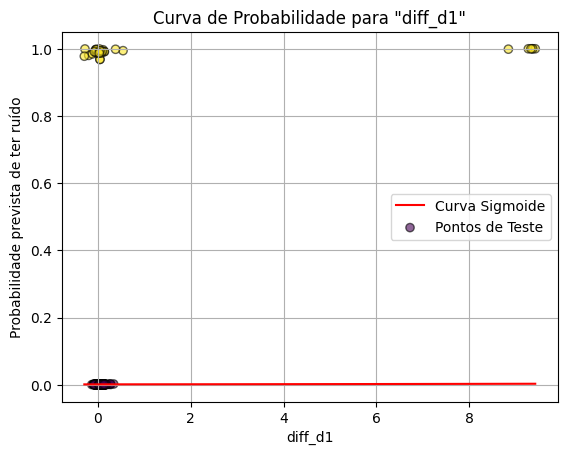

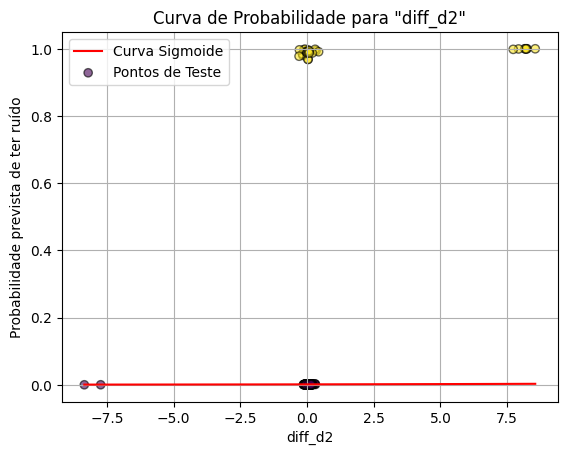

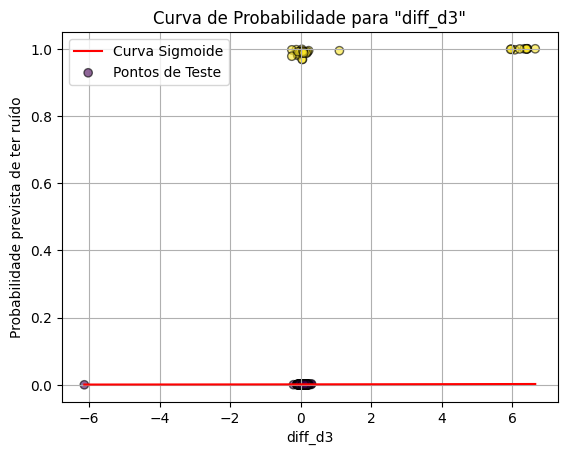

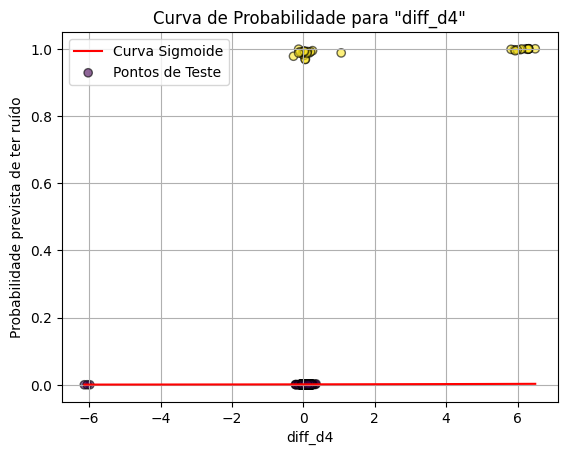

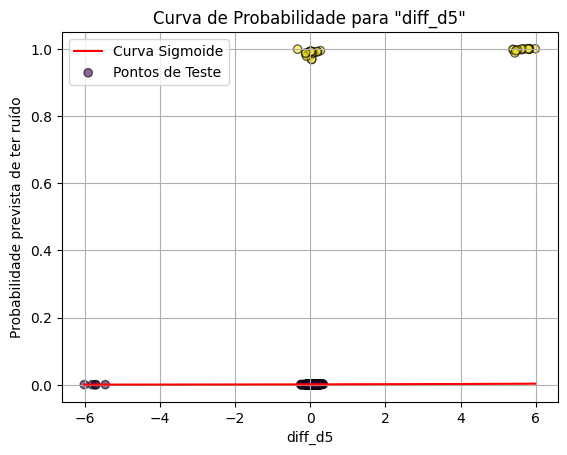

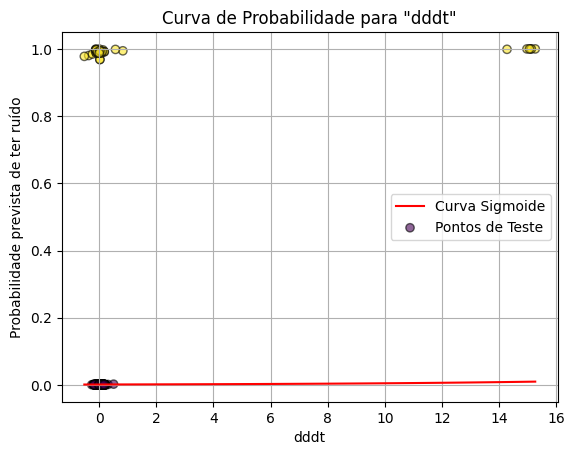

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Obter as probabilidades preditas para o conjunto de teste
y_prob = model.predict_proba(X_test)[:, 1]

# Obter os coeficientes e intercepto do modelo
b0 = model.intercept_[0]  # Intercepto
b = model.coef_[0]  # Coeficientes

# Criar a curva sigmoide para cada feature
for i, feature_name in enumerate(X_test.columns):
    X_feature = X_test[feature_name]

    # Criar um intervalo contínuo de valores da feature
    X_range = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)

    # Calcular a função logística (sigmoide)
    y_curve = 1 / (1 + np.exp(-(b0 + b[i] * X_range)))

    # Plotar a curva sigmoide
    plt.figure()
    plt.plot(X_range, y_curve, color='red', label="Curva Sigmoide")
    plt.scatter(X_feature, y_prob, c=y_test, cmap='viridis', edgecolors='k', alpha=0.6, label="Pontos de Teste")
    plt.xlabel(feature_name)
    plt.ylabel('Probabilidade prevista de ter ruído')
    plt.title(f'Curva de Probabilidade para "{feature_name}"')
    plt.legend()
    plt.grid()
    plt.show()


### Avalie a capacidade do modelo em classificar novas amostras utilizando as métricas de avaliação abordadas em aula:

Neste trabalho usamos 2 arquivos distintos contendo dados de sensores.

Para cada local de instalação do sensor existe uma característica física própria, por isso não é possível reaproveitar o treinamento de um sensor para outro sensor, ou seja, para cada arquivo é necessário fazer um treinamento.

Analisando os gráficos acima do sensor *device_833*, podemos ver que de acordo com as curvas sigmoides (cor vermelha) algumas features são irrelevantes para o modelo.


### Matriz de confusão com TP, TN, FP, FN

Matriz de Confusão:
 [[439   0]
 [  0  37]]


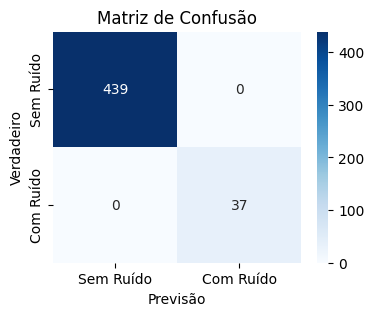

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Previsões no conjunto de teste
y_pred = model.predict(X_test)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Ruído', 'Com Ruído'], yticklabels=['Sem Ruído', 'Com Ruído'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


### Obtenha a Acurácia, Precisão, Sensibilidade (recall), especificidade e F1Score

In [48]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"\nMétricas de avaliação para o arquivo {device_833}")
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade (Recall):", recall)
print("Especificidade:", specificity)
print("F1 Score:", f1)



Métricas de avaliação para o arquivo data-1740136119968-noise.csv
Acurácia: 1.0
Precisão: 1.0
Sensibilidade (Recall): 1.0
Especificidade: 1.0
F1 Score: 1.0


### Apresente a curva ROC

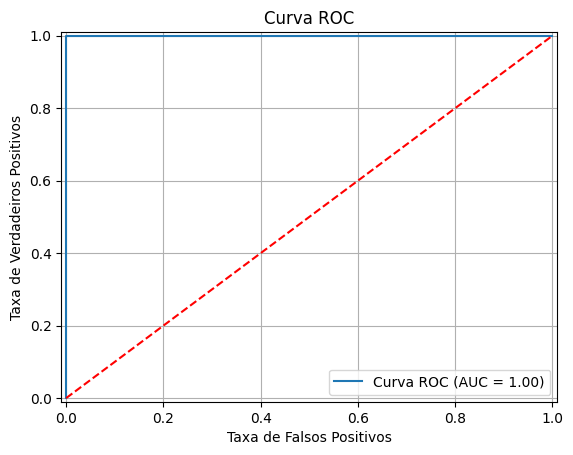

In [49]:
from sklearn.metrics import roc_curve, auc

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Métricas do treinamento usando o arquivo *device_468*

In [ ]:
df = load_file(device_468)
X = df[features] # seleciona as colunas de entrada
y = df[target] # seleciona a coluna de saída
test_size = 0.3 # 30% dos dados para teste

model, X_test, y_test, scaler = fit_model(X, y, test_size=0.3, scale=False)

# Previsões no conjunto de teste
y_pred = model.predict(X_test)
# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"\nMétricas de avaliação para o arquivo {device_468}")
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade (Recall):", recall)
print("Especificidade:", specificity)
print("F1 Score:", f1)


Métricas de avaliação para o arquivo data-1740190051056-noise.csv
Acurácia: 0.9935064935064936
Precisão: 1.0
Sensibilidade (Recall): 0.4
Especificidade: 1.0
F1 Score: 0.5714285714285714


### Comente os resultados com base na aplicação (dataset) utilizada  

Nesta atividade, utilizamos dois datasets. No primeiro dataset, foram gerados gráficos e avaliação de métricas, enquanto no segundo dataset realizamos apenas a avaliação das métricas do modelo.  

Ao analisar as curvas sigmoides do primeiro modelo, verificamos que algumas características não são relevantes para a previsão, porém, podem ser úteis para outros treinamentos.  

---

### Métricas de Avaliação  

#### Primeiro Treinamento  
Dataset: `data-1740136119968-noise.csv`  

- Acurácia: 1.0  
- Precisão: 1.0  
- Sensibilidade (Recall): 1.0  
- Especificidade: 1.0  
- F1 Score: 1.0  

O modelo apresentou acurácia, precisão, recall, especificidade e F1 Score máximos (100%), indicando que todas as amostras foram corretamente classificadas.


#### Segundo Treinamento  
Dataset: `data-1740190051056-noise.csv`  

- Acurácia: 0.9935  
- Precisão: 1.0  
- Sensibilidade (Recall): 0.4  
- Especificidade: 1.0  
- F1 Score: 0.57  

O modelo apresenta uma alta acurácia (99.35%) e precisão (100%), o que indica que ele é muito bom em prever amostras negativas (sem ruído).  

No entanto, a sensibilidade (recall) é baixa (40%), o que significa que o modelo não está identificando bem as amostras positivas (com ruído).  

A especificidade é alta (100%), indicando que o modelo conseguiu identificar todas as amostras negativas.  

Conclusão: O modelo foi bom em prever a ausência de ruído, porém precisa melhorar na detecção de ruído.
